# Read in the data

In [57]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [58]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [59]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [60]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [61]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [62]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [63]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [64]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [65]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [66]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

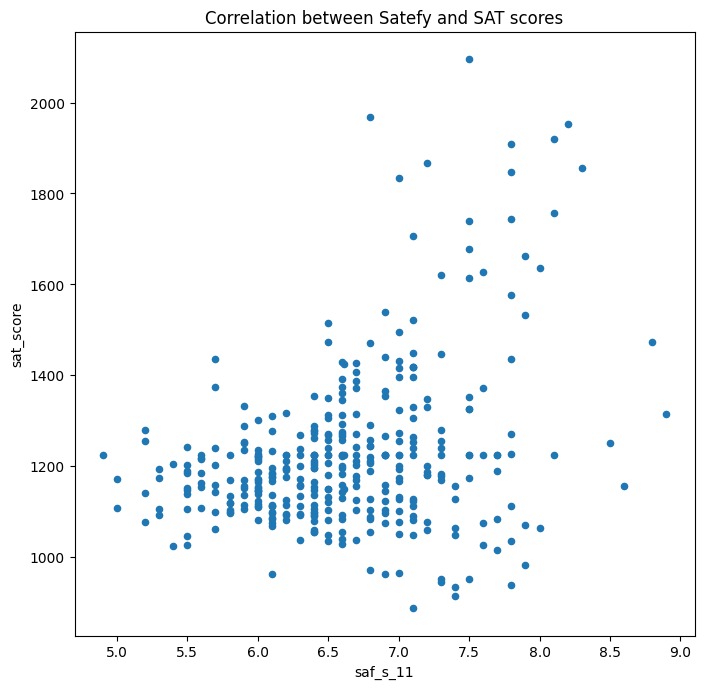

In [68]:
#Plot displays the relationship between Safety Scores and SAT scores 
combined.plot(kind="scatter", x="saf_s_11", y="sat_score", figsize=(8, 8), title="Correlation between Satefy and SAT scores")

#There seems to be a positive correlation between the safety scores that a school has and the average SAT scores, however this correlation is very weak when the safety scores are beteen 5.0 and 7.5 

# Investigating Racial Differences in SAT Scores

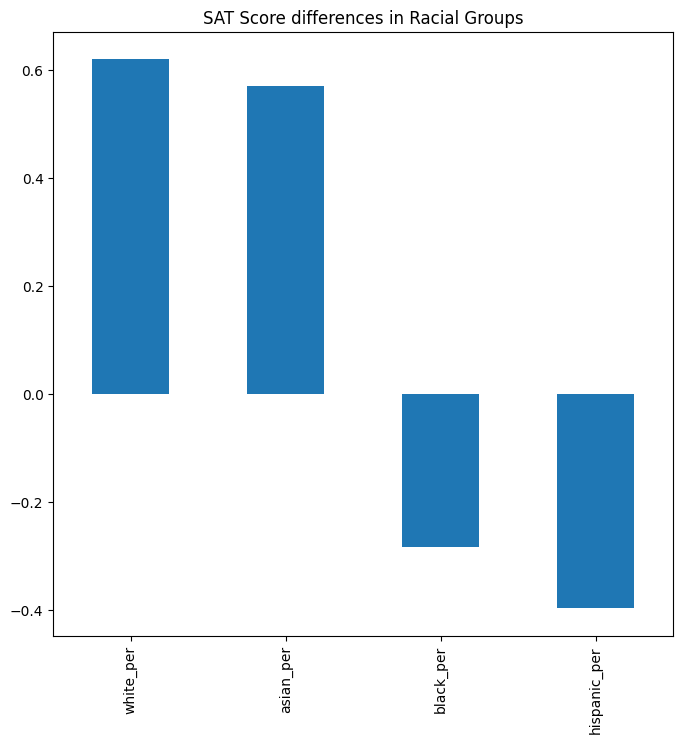

In [69]:
#Bar chart shows the correlation between different racial groups and SAT scores
racial_groups = ["white_per", "asian_per", "black_per", "hispanic_per"]

combined.corr()["sat_score"][racial_groups].plot.bar(figsize=(8,8), title="SAT Score differences in Racial Groups")
plt.show()

Schools with a higher percentage of asian and or white student are correlated with having higher SAT scores on average. Compared to schools with majority black and hispanic students where a higher percentage of these students is correlated with lower on average SAT scores. There are many reasons why this may be, one of them being that many of the schools where hispanic and black students attend may be institutions with less resources, funding and lower tax contributions which all lead to an overall lower quality of schools, teacher and overall education.

# Comparing Hispanic Students & SAT Scores

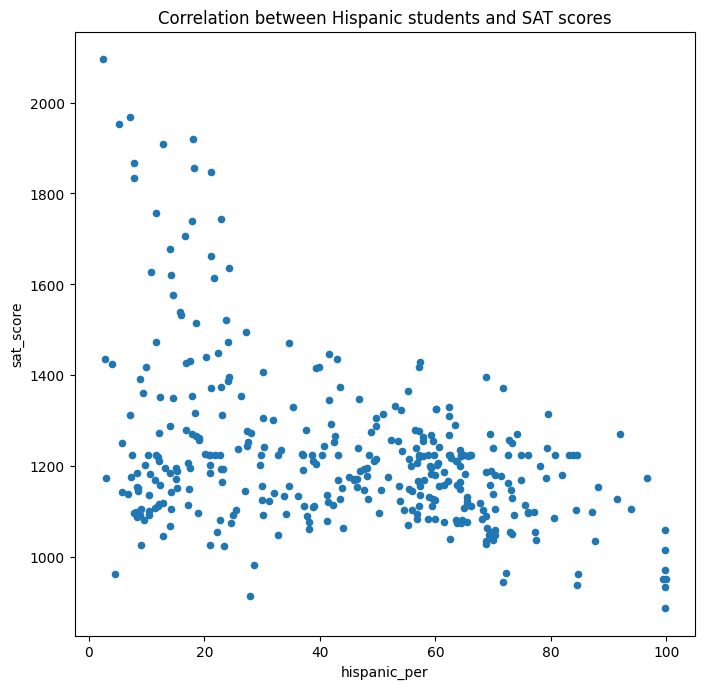

In [70]:
#Plot displays the relationship between hispanic student and SAT scores 
combined.plot(kind="scatter", x="hispanic_per", y="sat_score", figsize=(8, 8), title="Correlation between Hispanic students and SAT scores")

At first the data seems to indicate that there is a slight correlation between schools with a smaller percentage of hispanic students and higher SAT scores. However this as the percentages of hispanic students increases this correlation becomes slightly weaker. It is worth noting that the schools with 100% hispanic students have the lowest SAT scores on average

In [71]:
#researching school with hispanic percentage greater than 95%
ninefive_per_hispanic_schools = combined[combined["hispanic_per"] > 95]
print(ninefive_per_hispanic_schools)                                     

        DBN                                        SCHOOL NAME  \
44   02M542                      MANHATTAN BRIDGES HIGH SCHOOL   
82   06M348   WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL   
89   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...   
125  09X365                ACADEMY FOR LANGUAGE AND TECHNOLOGY   
141  10X342              INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
176  12X388   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE   
253  19K583                          MULTICULTURAL HIGH SCHOOL   
286  24Q296             PAN AMERICAN INTERNATIONAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
44                      66                            336.0   
82                      70                            380.0   
89                      56                            339.0   
125                     54                            315.0   
141                     49                            300.0   
176                     30 

These schools all seem to be schools aimed at new hispanic immigrants who have just entered the united states. A large portion of these immigrants most likely did not speak, read or write english prior to entering America. This would help explain the lower than average SAT scores for the schools with 100% hispanic students, as a large portion of those students are most likely just learning english before taking the SATs

In [72]:
#researching schools with hispanic percentage less than 10% and an average SAT score greater than 1800
hispanic_less10_and_over1800 = combined[(combined["hispanic_per"] > 10) & (combined["sat_score"] > 1800)]["school_name"]
print(hispanic_less10_and_over1800)

5                         Bard High School Early College
79     High School for Mathematics, Science and Engin...
155    High School of American Studies at Lehman College
302                          Townsend Harris High School
Name: school_name, dtype: object


These schools are all schools for either gifted students or student who are looking to enter colleges a couple years early. All of the schools listed are ranked in the top 100 best schools in the United States. These are all high ranking schools with very high admission standards. It would also be fair to conclude that these schools have an extremely experienced and high level faculty as well as adequate funding in order to give top level education to the students that attend their schools

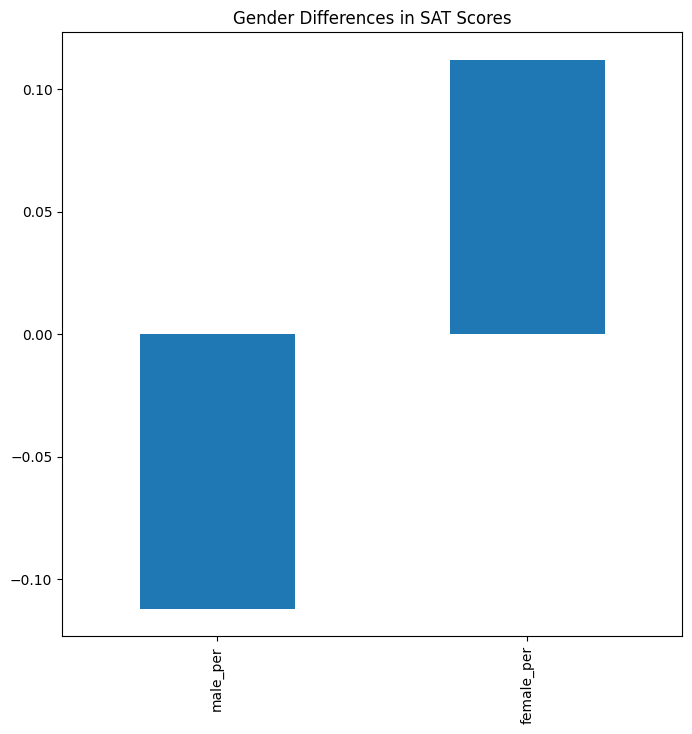

In [73]:
genders = ["male_per", "female_per"]
combined.corr()["sat_score"][genders].plot.bar(figsize=(8,8), title="Gender Differences in SAT Scores")

Schools with a higher percentage of female students have a positive correlation with higher SAT scores on average, while schools with a higher percentage of male students have a positive correlation with lower SAT scores on average

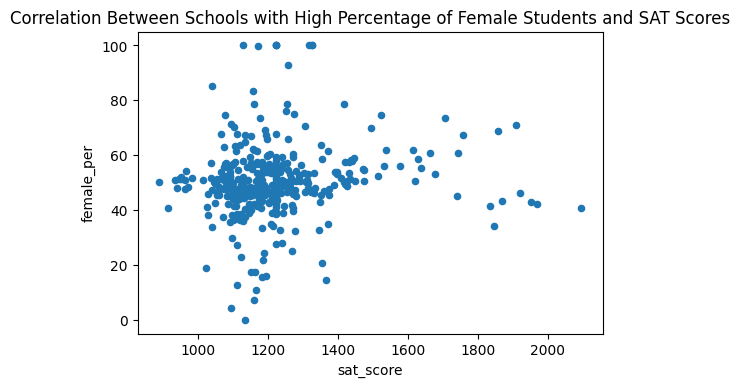

In [74]:
combined.plot.scatter(x="sat_score", y="female_per", title="Correlation Between Schools with High Percentage of Female Students and SAT Scores")

In [75]:
#Investigating schools with a high female population and high SAT scores
highfem_highsat = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["school_name"]
print(highfem_highsat)

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object


In [88]:
ap_per = combined["AP Test Takers "] / combined["total_enrollment"]
print(ap_per.head())

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
dtype: float64


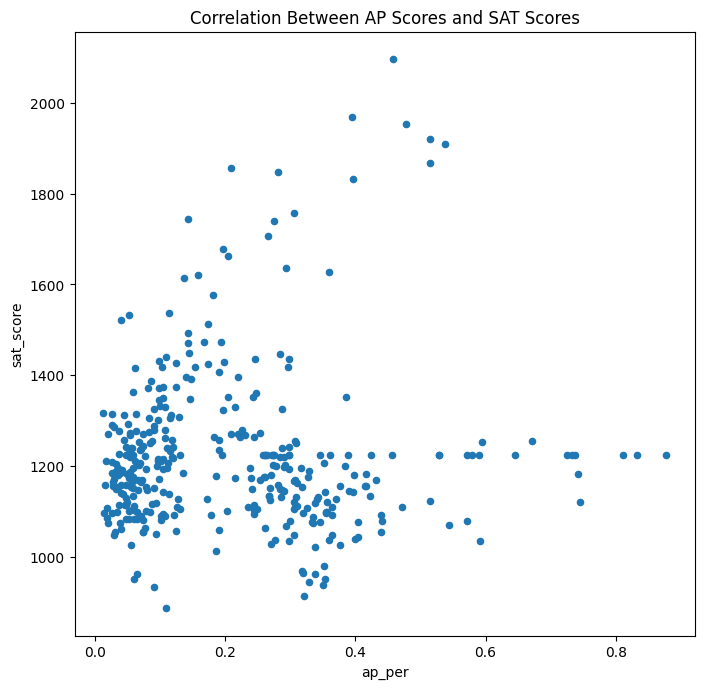

In [89]:
combined.plot(kind="scatter", x="ap_per", y="sat_score", figsize=(8,8), title="Correlation Between AP Scores and SAT Scores")

In [78]:
class_size.head(5)
#using class size to find the average class size

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


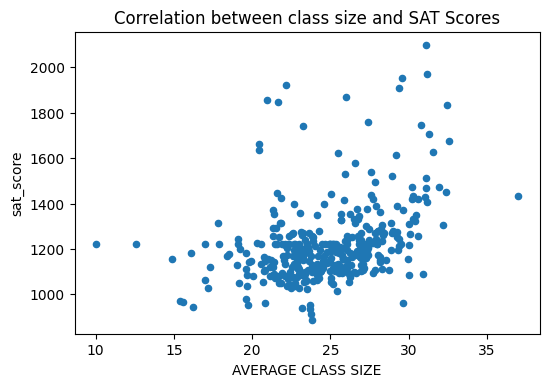

In [79]:
#creating scatterplot to determine if the is a correlation between class size and SAT Scores
combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score", title="Correlation between class size and SAT Scores")

It seems that there is a strong positive correlation between the avg size of students per class and SAT scores, it seems as the class sizes approach 20 to 30 student range the SAT scores increase. However it seems there are dimishing returns as classes with over 35 students see a significant drop in average SAT scores, schools with less than 20 schools also show lower on average SAT scores

# How many schools are there in our Dataset?

In [80]:
combined["SchoolName"].count()

363

There are 363 different schools in our NYC School Dataset

In [81]:
combined["school_dist"].unique()
#There are 363 different schools in the NYC school dataset and 32 unique school district

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

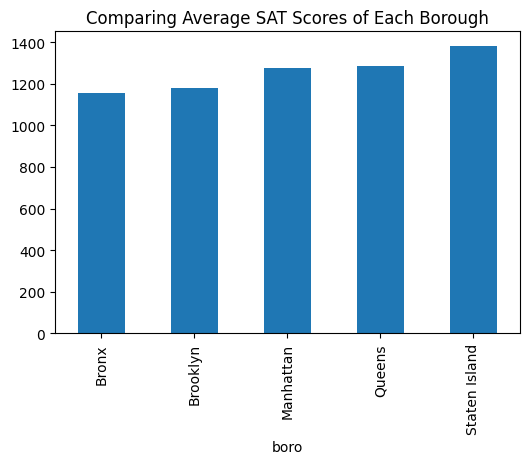

In [82]:
#comparing average SAT scores between New York Cities boroughs
combined.groupby("boro")["sat_score"].mean().plot(kind="bar", title="Comparing Average SAT Scores of Each Borough")

When comparing the average SAT scores between the different boroughs we see that on average Staten Island has the high SAT scores between the boroughs with and avg range of (1300 t0 1350) while the lowest on average borough is the bronx with an average SAT score from (1100 to 1150)

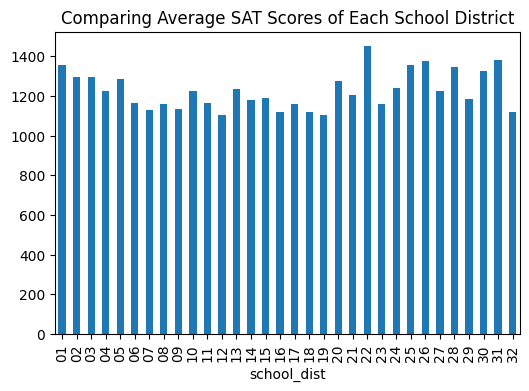

In [83]:
#comparing average SAT scores between different school districts
combined.groupby("school_dist")["sat_score"].mean().plot(kind="bar", title="Comparing Average SAT Scores of Each School District")

When comparing each district from 1 to 32 we that the school district with the hightest SAT scores on average is district 22, with district 31 being the second highest. The district with the lowest on average SAT scores is district 7.

In [84]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

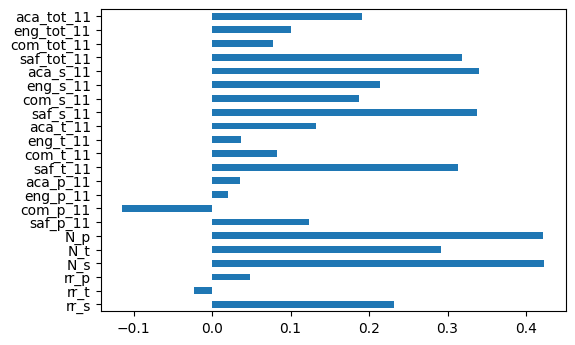

In [85]:
plt.plot()
combined.corr()["sat_score"][survey_fields].plot.barh()

In [86]:
High_survey = ["N_p", "N_t", "N_s","rr_s", "af_tot_11", "aca_s_11", "saf_s_11", "saf_t_11"]

In [87]:
print(High_survey)

['N_p', 'N_t', 'N_s', 'rr_s', 'af_tot_11', 'aca_s_11', 'saf_s_11', 'saf_t_11']


The schools with the higher number of parents reponse rates, Teacher response rates, Student response rates, Academic expectations based on student reponses, and academic expectation based on teacher respnose scores all have a higher correlation with a school having a higher SAT Score on average where communication based on parent responses has an negative correlation with average SAT scores. From this we can assume that a family with parents who don't speak English as their first language can impact the average SAT scores of their respective children 